In [1]:
from IPython.core.display import HTML
from datascience import *

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')

import os
import pandas as pd
import networkx as nx

In [2]:
# this is where you'd grab the data online
data_url = "https://snap.stanford.edu/data/wiki-talk-temporal.txt.gz"
# to make things faster in lecture, I pre-saved the file on my computer
#data_url = os.path.expanduser(os.path.join("~", "Dropbox", "data-explore", "wiki-talk", "wiki-talk-temporal.txt.gz"))

# Strength of weak ties in the Wiki Talk network

We'll look at the WikiTalk network, which is avaialble at the [SNAP data archive](https://snap.stanford.edu/data/wiki-Talk.html).

According to the website,

> The network contains all the users and discussion from the inception of Wikipedia till January 2008. 
>  * Nodes in the network represent Wikipedia users 
>  * A directed edge from node i to node j means that user i edited a talk page of user j at least once.
    


### Read in the datset

In [3]:
%%time

raw_data = pd.read_csv(data_url, sep=" ", header=None)

# rename the columns
raw_data = raw_data.rename(index=str, columns={0 : "from", 1 : "to", 2 : "time"})
raw_data.head()

CPU times: user 2.66 s, sys: 458 ms, total: 3.12 s
Wall time: 5.52 s


,from,to,time
0,0,1,1003638700
1,2,1,1030807083
2,3,1,1052654678
3,4,1,1094996163
4,5,1,1095491029


NB: this next cell takes about a minute

In [4]:
%%time

# create a network from the message logs
raw_net = nx.from_pandas_edgelist(raw_data, 
                                   source='from', 
                                   target='to', 
                                   edge_attr=['time'], 
                                   create_using=nx.MultiDiGraph())

CPU times: user 25.4 s, sys: 800 ms, total: 26.2 s
Wall time: 26.2 s


Simplify the network structure to turn it into an undirected network.

In [5]:
%%time

# filter out directed edges between nodes where connection is reciprocated
# (and also self-loops, if there are any)
di_edges_recip = [(u,v,d) for (u,v,d) in raw_net.edges if (v,u) in raw_net.edges and v != u]

len(di_edges_recip)

CPU times: user 10.7 s, sys: 92.5 ms, total: 10.8 s
Wall time: 10.8 s


2348912

In [6]:
%%time

# now create an undirected network with edges weighted by the number of interactions
new_net = nx.Graph()
for edge in di_edges_recip:
    # if the edge is already in the network, add one to its weight
    if (edge[0], edge[1]) in new_net.edges:
        new_net[edge[0]][edge[1]]['weight'] = new_net[edge[0]][edge[1]]['weight'] + 1
    # otherwise, add it
    else:
        new_net.add_edge(edge[0], edge[1], weight=1)
        


CPU times: user 4.85 s, sys: 52.3 ms, total: 4.9 s
Wall time: 4.9 s


### Some general info about the network

Number of nodes and edges:

In [7]:
print("Number of nodes: ", new_net.number_of_nodes())
print("Number of edges: ", new_net.number_of_edges())
print("Average degree: ", 2*new_net.number_of_edges()/new_net.number_of_nodes())

Number of nodes:  93875
Number of edges:  342775
Average degree:  7.302796271637816


Extract the degrees into a Table, which we'll use to make a histogram of the degree distribution

In [8]:
new_net_degrees = Table().with_columns([
    'id', new_net.nodes(),
    'degree', [d for (n,d) in new_net.degree] # this  gets list of degree values from the (node,degree) pairs
])

A very small number of nodes have very large degrees; for example, the largest degree is almost 1200

In [9]:
np.max(new_net_degrees['degree'])

1197

... so to keep the histogram readable, let's only plot up to the 95th percentile

In [10]:
np.percentile(new_net_degrees['degree'], 95)

26.0

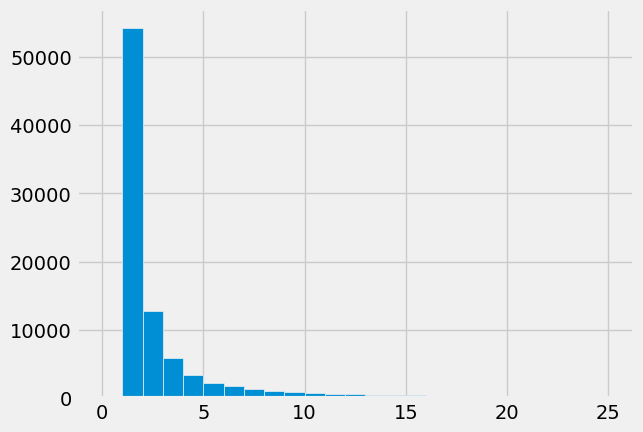

In [11]:
plt.hist(new_net_degrees['degree'], bins=np.arange(0,26,1));

Look at the number of components and their size:

In [12]:
%%time

# get the giant component
new_net_components = sorted(nx.connected_components(new_net), key=len, reverse=True)

print("Number of components:", len(new_net_components))
print("frac nodes in GC: ", new_net.subgraph(new_net_components[0]).number_of_nodes() / new_net.number_of_nodes())

Number of components: 958
frac nodes in GC:  0.9784607190412783
CPU times: user 238 ms, sys: 4.57 ms, total: 242 ms
Wall time: 241 ms


Pick out the giant component

In [13]:
new_net_gc = new_net.subgraph(new_net_components[0])

Recall that Onnela et al (2007) introduced the concept of *neighborhood overlap* as a way of quantifying how 'bridge-like' an edge is.  The *neighborhood overlap* of an edge joining a node A and a node B is defined to be

$$
\text{neighborhood overlap} = \frac{\text{number of nodes who are neighbors of both A and B}}{\text{number of nodes who are neighbors of at least one of A or B}}
$$

where the denominator does not count $A$ or $B$.

The neighborhood overlap ranges from 0 to 1. For an edge that is a *local bridge*, the neighborhood overlap would be 0. For a bridge that joins two nodes who are completely interconnected (i.e., a very not 'bridge-like' edge), the neighborhood overlap would be 1.

Let's calculate the neighborhood overlap of every edge in the giant component of our wiki talk network.

(This takes about a minute and a half to do)

In [14]:
%%time

# calculate the neighborhood overlap for each edge
for edge in new_net_gc.edges:
    
    # grab the neighbors of the node at either end of this edge
    # (not counting the two nodes involved in the edge)
    u_nbrs = set(new_net_gc.neighbors(edge[0])) - set([edge[1]])
    v_nbrs = set(new_net_gc.neighbors(edge[1])) - set([edge[0]])
    
    # figure out how many neighbors the neighborhoods have in common (numerator)
    common_nbrs = len(u_nbrs & v_nbrs) 
    
    # figure out how many unique neighbors they have between them
    poss_nbrs = len(u_nbrs | v_nbrs)
    
    # calculate the neighborhood overlap and add it to the edge
    # as an attribute
    new_net_gc[edge[0]][edge[1]]['nbhd_overlap'] = common_nbrs / poss_nbrs

CPU times: user 44 s, sys: 106 ms, total: 44.1 s
Wall time: 44.2 s


### Plot the relationship between tie strength and neighborhood overlap

As we saw in lecture, Onnela et al (2007) found that in their cell phone call network, edges that were bridge-like -- that is, edges with low values of neighborhood overlap -- tended to be weak ties.

Let's see if that pattern holds up in the giant component of the wiki talk data.

Recall that we added neighborhood overlap to the edges in the giant component. To make plotting easier, let's now convert the giant component back into an edge list:

In [15]:
net_df = nx.to_pandas_edgelist(new_net_gc)

net_df

,source,target,nbhd_overlap,weight
0,2,97,0.049645,4
1,2,111,0.039648,19
2,2,316,0.038202,6
3,2,321,0.050633,3
4,2,162,0.083333,3
...,...,...,...,...
341693,543706,543705,0.000000,3
341694,616580,538927,0.000000,2
341695,1006240,1006238,0.000000,4
341696,669876,669877,0.000000,2


<AxesSubplot:xlabel='weight', ylabel='nbhd_overlap'>

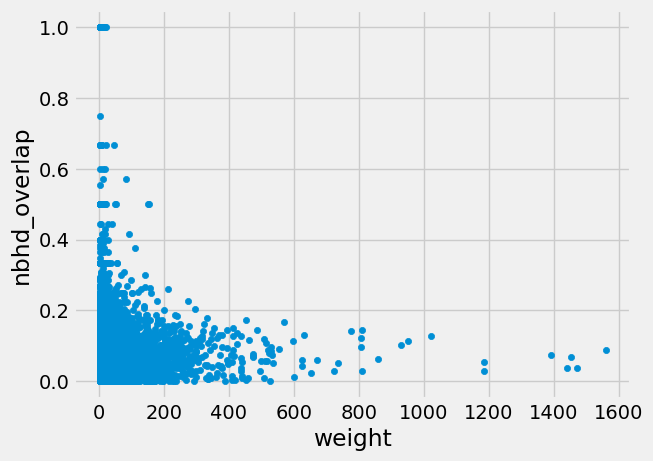

In [16]:
net_df.plot(kind='scatter', x='weight', y='nbhd_overlap')

It's hard to tell what's going on from the plot above; there's a point for each edge (about 340k in total).

We can plot each point with partial transparency to try to reveal where the mass of the data lies:

<AxesSubplot:xlabel='weight', ylabel='nbhd_overlap'>

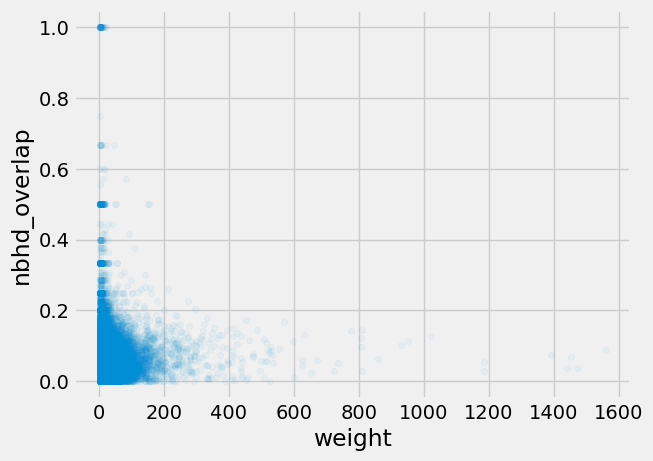

In [17]:
net_df.plot(kind='scatter', x='weight', y='nbhd_overlap', alpha=.05)

... but it's still pretty hard to really tell what's going on.

Let's group the ties into 10 different groups of equal size, from lowest weight to highest weight. Then we'll calculate the average neighborhood overlap within each of these groups.  (You might remember that Onnela et al did something similar in their analysis.) 

In [18]:
net_df['tie_strength'] = pd.qcut(net_df['weight'], 10, duplicates='drop')

Let's look at the categories that Pandas created for us:

In [19]:
net_df.groupby('tie_strength')['nbhd_overlap'].mean()

tie_strength
(1.999, 3.0]      0.010859
(3.0, 4.0]        0.013050
(4.0, 5.0]        0.014897
(5.0, 6.0]        0.016463
(6.0, 8.0]        0.019234
(8.0, 12.0]       0.023319
(12.0, 1561.0]    0.037188
Name: nbhd_overlap, dtype: float64

In [20]:
net_agg = pd.DataFrame(net_df.groupby('tie_strength')['nbhd_overlap'].mean())
net_agg['tie_strength'] = net_agg.index
net_agg

,nbhd_overlap,tie_strength
tie_strength,,
"(1.999, 3.0]",0.010859,"(1.999, 3.0]"
"(3.0, 4.0]",0.013050,"(3.0, 4.0]"
"(4.0, 5.0]",0.014897,"(4.0, 5.0]"
"(5.0, 6.0]",0.016463,"(5.0, 6.0]"
"(6.0, 8.0]",0.019234,"(6.0, 8.0]"
"(8.0, 12.0]",0.023319,"(8.0, 12.0]"
"(12.0, 1561.0]",0.037188,"(12.0, 1561.0]"


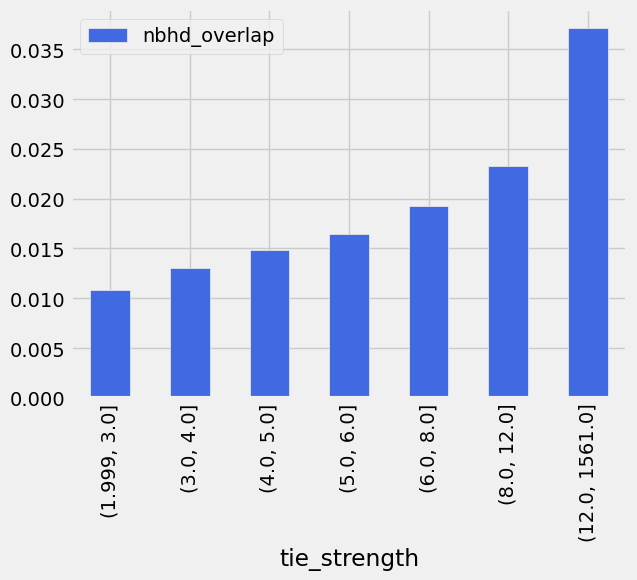

In [21]:
net_agg.plot(kind='bar', x='tie_strength', y='nbhd_overlap', color='royalblue');

This looks roughly consistent with the Onnela et al finding we talked about in lecture: weak ties tend to have lower neighborhood overlap, making them more like local bridges.

The analysis above roughly parallels the Onnela et al. paper. However, a student made an astute observation: **the strength of weak ties hypothesis really predicts that bridges will be weak ties; it does not necessarily imply that all weak ties are bridges**. This suggests that we should look at how the bridginess of a tie is related to average tie strength. In other words, it suggests that we want to flip the plot above so that neighborhood overlap is on the x axis and average tie strength is on the y axis.

Let's do that now:

In [22]:
net_df['no_bin'] = pd.qcut(net_df['nbhd_overlap'], 10, duplicates='drop')

In [23]:
net_df.groupby('no_bin')['weight'].mean()

no_bin
(-0.001, 0.005]      4.652015
(0.005, 0.0104]      5.838058
(0.0104, 0.0173]     6.476642
(0.0173, 0.0275]     7.336267
(0.0275, 0.0458]     9.511938
(0.0458, 1.0]       16.187390
Name: weight, dtype: float64

In [24]:
net_agg2 = pd.DataFrame(net_df.groupby('no_bin')['weight'].mean())
net_agg2['nbhd_overlap'] = net_agg2.index
net_agg2

,weight,nbhd_overlap
no_bin,,
"(-0.001, 0.005]",4.652015,"(-0.001, 0.005]"
"(0.005, 0.0104]",5.838058,"(0.005, 0.0104]"
"(0.0104, 0.0173]",6.476642,"(0.0104, 0.0173]"
"(0.0173, 0.0275]",7.336267,"(0.0173, 0.0275]"
"(0.0275, 0.0458]",9.511938,"(0.0275, 0.0458]"
"(0.0458, 1.0]",16.187390,"(0.0458, 1.0]"


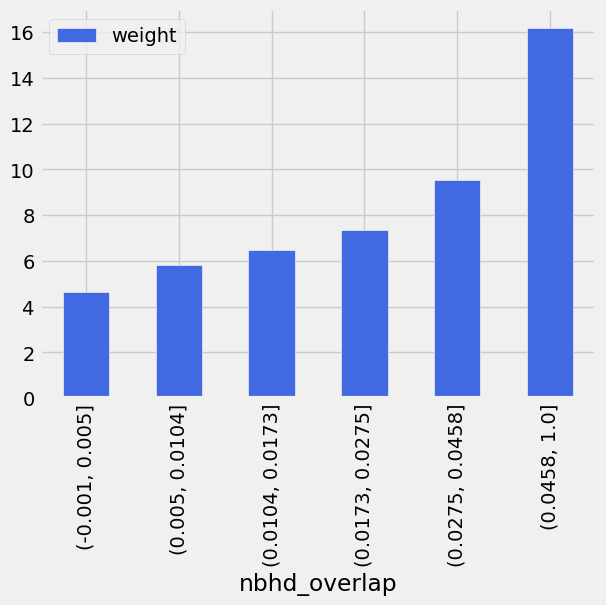

In [25]:
net_agg2.plot(kind='bar', x='nbhd_overlap', y='weight', color='royalblue');

We see that, as the strength of weak ties hypothesis would predict, neighborhood overlap is positively associated with tie strength: the bins with larger neighborhood overlap values have higher average weights (tie strength).